In [ ]:
import pandas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

## Data Extraction
We obtain the processed dataset

In [2]:
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")


In [3]:
X_train.shape

(98664, 300)

Normalize the data just in case

In [4]:
# 🔹 3. Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Evaluation Metrics

We define a function to retrieve the evaluation metrics for each model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

scores = {}

def round_predictions(predictions, threshold=0.5):
    """
    Rounds predictions to integer values from 1 to 5 using a threshold.
    """
    rounded_preds = np.floor(predictions + threshold)  # Apply rounding using the threshold
    return np.clip(rounded_preds, 0, 4)  # Ensure values are within the range [0,4]

def score_metrics(algorithm, prediction, y_test, parameters, threshold=0.5):
    # Save raw predictions to a file before rounding
    prediction_df = pd.DataFrame({"Prediction": prediction})
    prediction_df.to_csv(f"predictions/{algorithm}_predictions.csv", index=False)

    # Apply rounding to predictions
    prediction_rounded = round_predictions(prediction, threshold)

    # Calculate regression metrics
    mae = mean_absolute_error(y_test, prediction_rounded)
    mse = mean_squared_error(y_test, prediction_rounded)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, prediction_rounded)

    # Store results along with the parameters used
    scores[algorithm] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Threshold": threshold,
        "params": parameters
    }

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, prediction_rounded, labels=[0, 1, 2, 3, 4])

    # Print results in a table format
    print(f'''
+---------------------------------------------------+
        {algorithm} - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): {mae:.4f}
    MSE  (Mean Squared Error): {mse:.4f}
    RMSE (Root Mean Squared Error): {rmse:.4f}
    R² Score (Coefficient of Determination): {r2:.4f}
    Threshold used: {threshold}
+---------------------------------------------------+
    ''')

    # Row and column labels
    labels = [0, 1, 2, 3, 4]
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    # Labels and title
    plt.xlabel("Prediction")
    plt.ylabel("Actual Value")
    plt.title("Confusion Matrix")

    # Show the plot
    plt.show()
    
    return conf_matrix


## Train Baseline

In [ ]:

# Inicialize models
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Linear Regression": LinearRegression(),
    "Neural Network": MLPRegressor(max_iter=500, random_state=42),
    "KNN Regressor": KNeighborsRegressor()
}

# Train models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    try:
        model.fit(X_train, y_train)
        trained_models[name] = model
        print(f"{name} successfully trained.")
        
        # Make predictions
        predictions = model.predict(X_test)

        # Save predictions in a CSV file
        filename = f"baseline/{name.replace(' ', '_')}_predictions.csv"
        pd.DataFrame(predictions, columns=["Prediction"]).to_csv(filename, index=False)
        print(f"Predictions saved on {filename}.")
    except Exception as e:
        print(f"Failed to train {name}: {e}")

Training Naive Bayes...
Naive Bayes succesfully trained.
Predictions saved on Naive_Bayes_predictions.csv.
Training Logistic Regression...


/home/jaume/Escritorio/Ultim_Semestre/Comp.ML/Practicas/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression succesfully trained.
Predictions saved on Logistic_Regression_predictions.csv.
Training SVM...
SVM succesfully trained.
Predictions saved on SVM_predictions.csv.
Training Decision Tree...
Decision Tree succesfully trained.
Predictions saved on Decision_Tree_predictions.csv.
Training Random Forest...
Random Forest succesfully trained.
Predictions saved on Random_Forest_predictions.csv.
Training XGBoost...
XGBoost succesfully trained.
Predictions saved on XGBoost_predictions.csv.


## MiniBatch

Due to the large ammount of samples, it would take to much time to gridsearch using all the dataset. To solve this problem we will take a subset of the 10% of the dataset. This subset will be selected to maintain the class proportions from the original dataset. We will do a gridsearch with this subset to obtain the best parameters, then we will use those parameter to train the model with the complete dataset.

In [ ]:
X_muestra, _, y_muestra, _ = train_test_split(
    X_train, 
    y_train, 
    train_size=0.1,  # Take 10% of the data
    stratify=y_train,  # Maintain the class proportions
    random_state=42
)

## Training

### Decision Trees

We have seen in the baseline that the basic model has problems, probably due to overfitting. We will add limitations in features and depth to try to solve this.

In [ ]:
# Define hyperparameters
params = {
    'max_depth': [4, 6, 8, 10, 12, None],  # Test higher values and None
    'min_samples_split': [100, 150, 200, 500],  # Increase to avoid overfitting
    'min_samples_leaf': [10, 20, 40, 60],  # Control the minimum leaf size
    'max_features': ['auto', 'sqrt', 'log2'],  # Limit the number of features
    'criterion': ['squared_error', 'absolute_error']  # Test both criteria
}

# Decision Tree Model for Regression
dt = DecisionTreeRegressor()

# GridSearchCV to optimize hyperparameters
decision_tree = GridSearchCV(dt, param_grid=params, cv=5, verbose=2, n_jobs=-1)

# Train model
decision_tree.fit(X_muestra, y_muestra)
# dt.fit(X_train, y_train)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=100; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=150; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=150; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=20, min_samples_split=150; total time=   0.0s
[CV] END criterion=squared_error,

/home/jaume/Escritorio/Ultim_Semestre/Comp.ML/Practicas/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
960 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
438 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jaume/Escritorio/Ultim_Semestre/Comp.ML/Practicas/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jaume/Escritorio/Ultim_Semestre/Comp.ML/Practicas/venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/jaume/Escritorio/Ultim_Seme

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [4, 6, 8, 10, 12, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [10, 20, 40, 60],
                         'min_samples_split': [100, 150, 200, 500]},
             verbose=2)

In [ ]:
mejores_parametros = decision_tree.best_params_
mejores_parametros

{'criterion': 'squared_error',
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 40,
 'min_samples_split': 100}

In [ ]:
# Train with all the dataset
modelo_final_dt = DecisionTreeRegressor(**mejores_parametros)
modelo_final_dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=40,
                      min_samples_split=100)


+---------------------------------------------------+
        Decision Tree - Evaluación del Modelo de Regresión                         
+---------------------------------------------------+
    MAE  (Error Absoluto Medio): 0.7942
    MSE  (Error Cuadrático Medio): 1.2070
    RMSE (Raíz del MSE): 1.0986
    R² Score (Coef. de determinación): 0.4664
    Threshold utilizado: 0.5
+---------------------------------------------------+
    


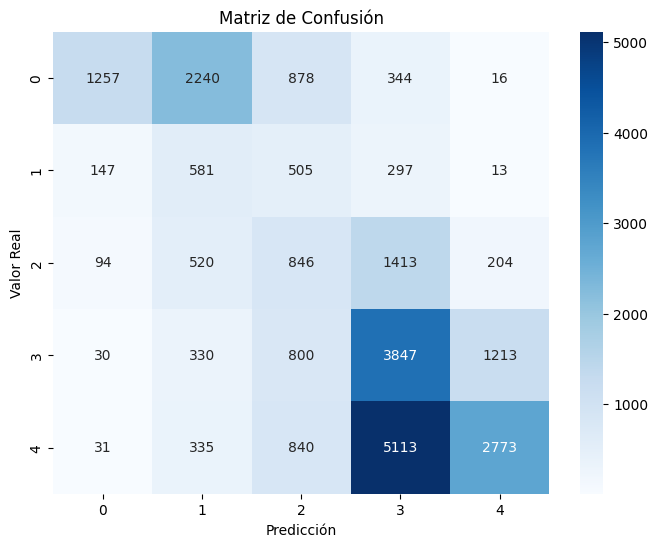

array([[1257, 2240,  878,  344,   16],
       [ 147,  581,  505,  297,   13],
       [  94,  520,  846, 1413,  204],
       [  30,  330,  800, 3847, 1213],
       [  31,  335,  840, 5113, 2773]])

In [ ]:
prediction=modelo_final_dt.predict(X_test)
score_metrics("Decision_Tree",prediction,y_test,mejores_parametros)

### Random Forest

In [ ]:
params_rf = {
    'criterion': ['squared_error'], 
    'bootstrap': [True],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],  
    'n_estimators': [500, 600, 800, 1000],  
    'random_state': [2]
}

# Random Forest model for regression
rfr = RandomForestRegressor()

# GridSearchCV to find the best hyperparameters
random_forest = GridSearchCV(rfr, param_grid=params_rf, cv=5, verbose=2, n_jobs=-1)

# Train model
random_forest.fit(X_muestra, y_muestra)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=14.2min
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=14.3min
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=14.5min
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=14.6min
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=14.6min
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=500, random_state=2; total time=14.7

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['squared_error'],
                         'max_depth': [5, 10, 20], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 3],
                         'n_estimators': [500, 600, 800, 1000],
                         'random_state': [2]},
             verbose=2)

In [ ]:
mejores_parametros = random_forest.best_params_
mejores_parametros

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'random_state': 2}

In [ ]:
modelo_final_rf = RandomForestRegressor(**mejores_parametros)
modelo_final_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=2)


+---------------------------------------------------+
        Random Forest - Evaluación del Modelo de Regresión                         
+---------------------------------------------------+
    MAE  (Error Absoluto Medio): 0.7032
    MSE  (Error Cuadrático Medio): 0.9967
    RMSE (Raíz del MSE): 0.9983
    R² Score (Coef. de determinación): 0.5594
    Threshold utilizado: 0.5
+---------------------------------------------------+
    


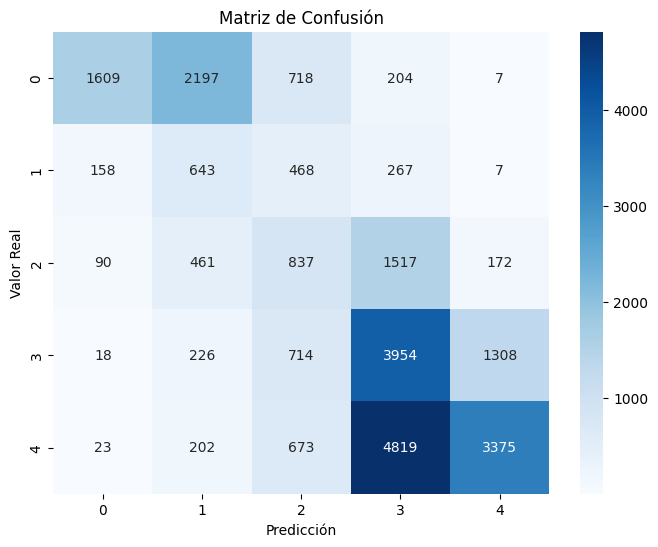

array([[1609, 2197,  718,  204,    7],
       [ 158,  643,  468,  267,    7],
       [  90,  461,  837, 1517,  172],
       [  18,  226,  714, 3954, 1308],
       [  23,  202,  673, 4819, 3375]])

In [ ]:
prediction=modelo_final_rf.predict(X_test)
score_metrics("Random_Forest",prediction,y_test,mejores_parametros)

### XGBoost

In [ ]:
params_xgb = {
    'objective': ['reg:squarederror'],  
    'max_depth': [6, 8],  
    'reg_alpha': [2, 2.5, 3.0],  # L1 Regularization
    'eta': [0.01, 0.05, 0.1],  # Learning rate
    'subsample': [0.6, 0.7, 0.8],  # Controls how much data is used in each tree
    'random_state': [2],
    'eval_metric': ['rmse'], 
    'booster': ['gbtree'] 
}

# Create the XGBoost model for regression
xgbR = XGBRegressor()

# GridSearchCV to find the best hyperparameters
xgboost = GridSearchCV(xgbR, param_grid=params_xgb, cv=5, verbose=2)

# Train the model
xgboost.fit(X_muestra, y_muestra)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=6, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.6; total time=   4.1s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=6, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.6; total time=   3.3s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=6, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.6; total time=   3.8s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=6, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.6; total time=   3.4s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=6, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.6; total time=   3.6s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=6, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.7; total time=   3

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'booster': ['gbtree'], 'eta': [0.01, 0.05, 0.1],
                         'eval_metric': ['rmse'], 'max_depth': [6, 8],
                         'objective': ['reg:squarederror'], 'random_state': [2],
                         'reg_alpha': [2, 2.5, 3.0],
                         'subsample': [0.6, 0.7, 0.8]},
             verbose=2)

In [ ]:
mejores_parametros = xgboost.best_params_
mejores_parametros

{'booster': 'gbtree',
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'objective': 'reg:squarederror',
 'random_state': 2,
 'reg_alpha': 2.5,
 'subsample': 0.7}

In [ ]:
# Crear el modelo final con los mejores parámetros
modelo_final_xg = XGBRegressor(**mejores_parametros)

# Entrenar el modelo con todo el dataset
modelo_final_xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)


+---------------------------------------------------+
        XGBoost - Evaluación del Modelo de Regresión                         
+---------------------------------------------------+
    MAE  (Error Absoluto Medio): 0.6823
    MSE  (Error Cuadrático Medio): 0.9710
    RMSE (Raíz del MSE): 0.9854
    R² Score (Coef. de determinación): 0.5708
    Threshold utilizado: 0.5
+---------------------------------------------------+
    


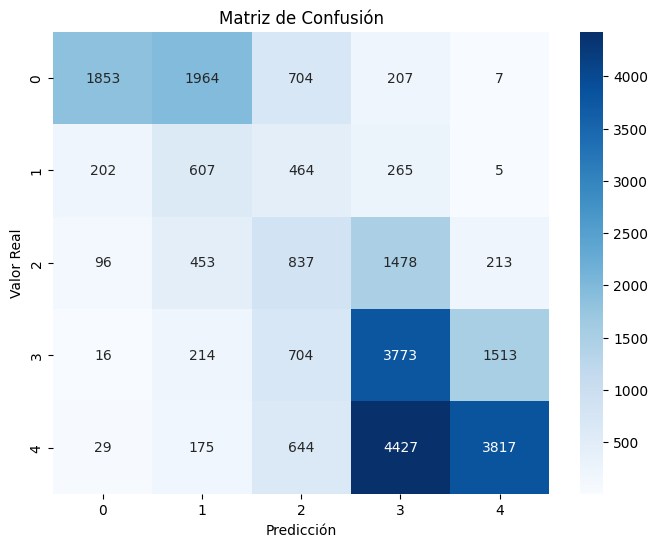

array([[1853, 1964,  704,  207,    7],
       [ 202,  607,  464,  265,    5],
       [  96,  453,  837, 1478,  213],
       [  16,  214,  704, 3773, 1513],
       [  29,  175,  644, 4427, 3817]])

In [ ]:
prediction=modelo_final_xg.predict(X_test)
#prediction=xgbR.predict(X_test)

score_metrics("XGBoost",prediction,y_test,mejores_parametros)

### Linear Regression

### Neural Network

### KNN Regressor

## Final results

To see the final results, lets load all the files generated and plot the metrics


+---------------------------------------------------+
        XGBoost - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.6776
    MSE  (Mean Squared Error): 0.9784
    RMSE (Root Mean Squared Error): 0.9891
    R² Score (Coefficient of Determination): 0.5675
    Threshold used: 0.5
+---------------------------------------------------+
    


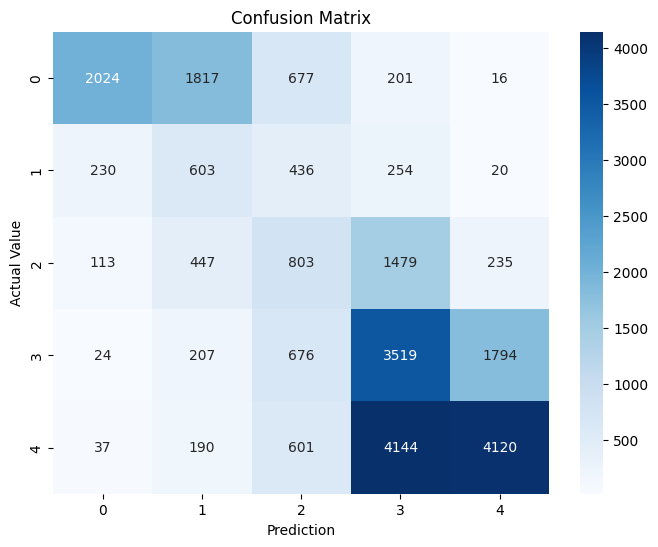


+---------------------------------------------------+
        SVM - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.6262
    MSE  (Mean Squared Error): 0.9020
    RMSE (Root Mean Squared Error): 0.9497
    R² Score (Coefficient of Determination): 0.6013
    Threshold used: 0.5
+---------------------------------------------------+
    


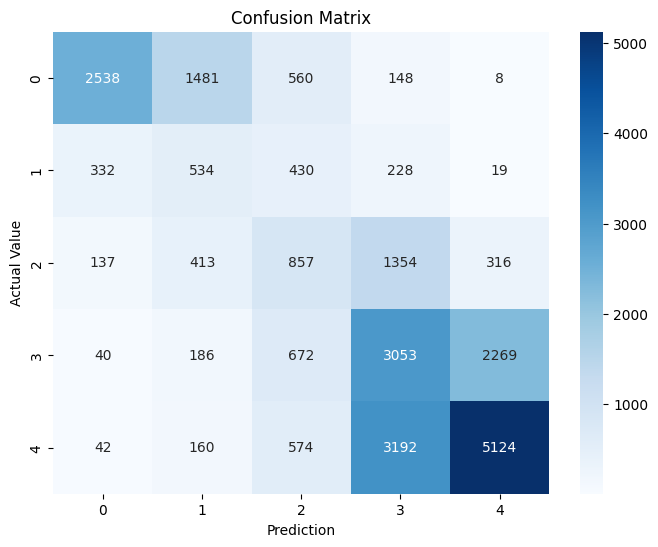


+---------------------------------------------------+
        Decision_Tree - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.9041
    MSE  (Mean Squared Error): 1.8508
    RMSE (Root Mean Squared Error): 1.3604
    R² Score (Coefficient of Determination): 0.1819
    Threshold used: 0.5
+---------------------------------------------------+
    


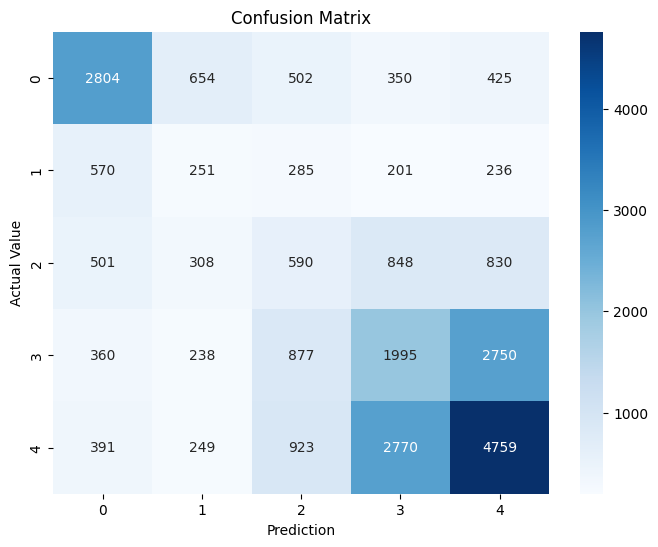


+---------------------------------------------------+
        Random_Forest - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.7064
    MSE  (Mean Squared Error): 0.9968
    RMSE (Root Mean Squared Error): 0.9984
    R² Score (Coefficient of Determination): 0.5593
    Threshold used: 0.5
+---------------------------------------------------+
    


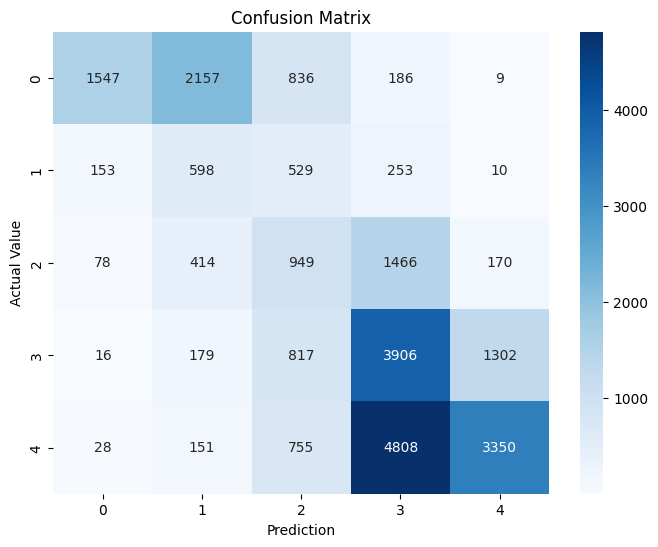


+---------------------------------------------------+
        Naive_Bayes - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.8997
    MSE  (Mean Squared Error): 1.8178
    RMSE (Root Mean Squared Error): 1.3482
    R² Score (Coefficient of Determination): 0.1965
    Threshold used: 0.5
+---------------------------------------------------+
    


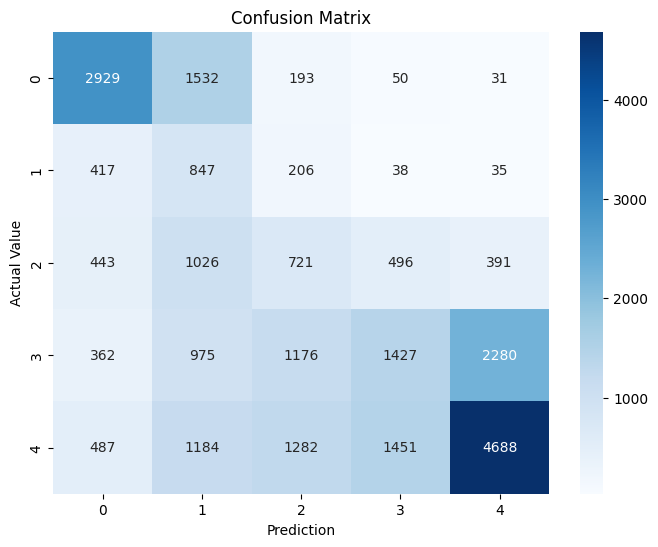


+---------------------------------------------------+
        Logistic_Regression - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.6497
    MSE  (Mean Squared Error): 1.2800
    RMSE (Root Mean Squared Error): 1.1314
    R² Score (Coefficient of Determination): 0.4342
    Threshold used: 0.5
+---------------------------------------------------+
    


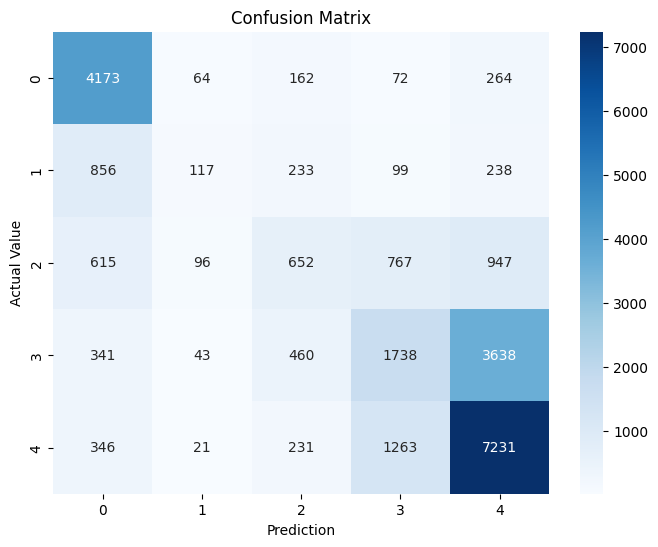

In [ ]:
import numpy as np
import pandas as pd
import glob
import os

# Load y_test from the .npy file
y_test = np.load("y_test.npy")


# Get all prediction files
prediction_files = glob.glob("predictions/*_predictions.csv")

# Iterate over the prediction files
for file in prediction_files:
    # Extract the algorithm name from the file name
    algorithm = os.path.basename(file).replace("_predictions.csv", "")
    
    # Load predictions from the CSV file, considering it has headers
    predictions_df = pd.read_csv(file)  # Read CSV as DataFrame
    
    # Assuming the first column contains the predictions
    predictions = predictions_df.iloc[:, 0].values.flatten()  # Convert to 1D array
    if len(y_test)==len(predictions):
        # Call the function with the specified parameters
        score_metrics(algorithm, predictions, y_test, parameters=None)
    else:
        print(algorithm)


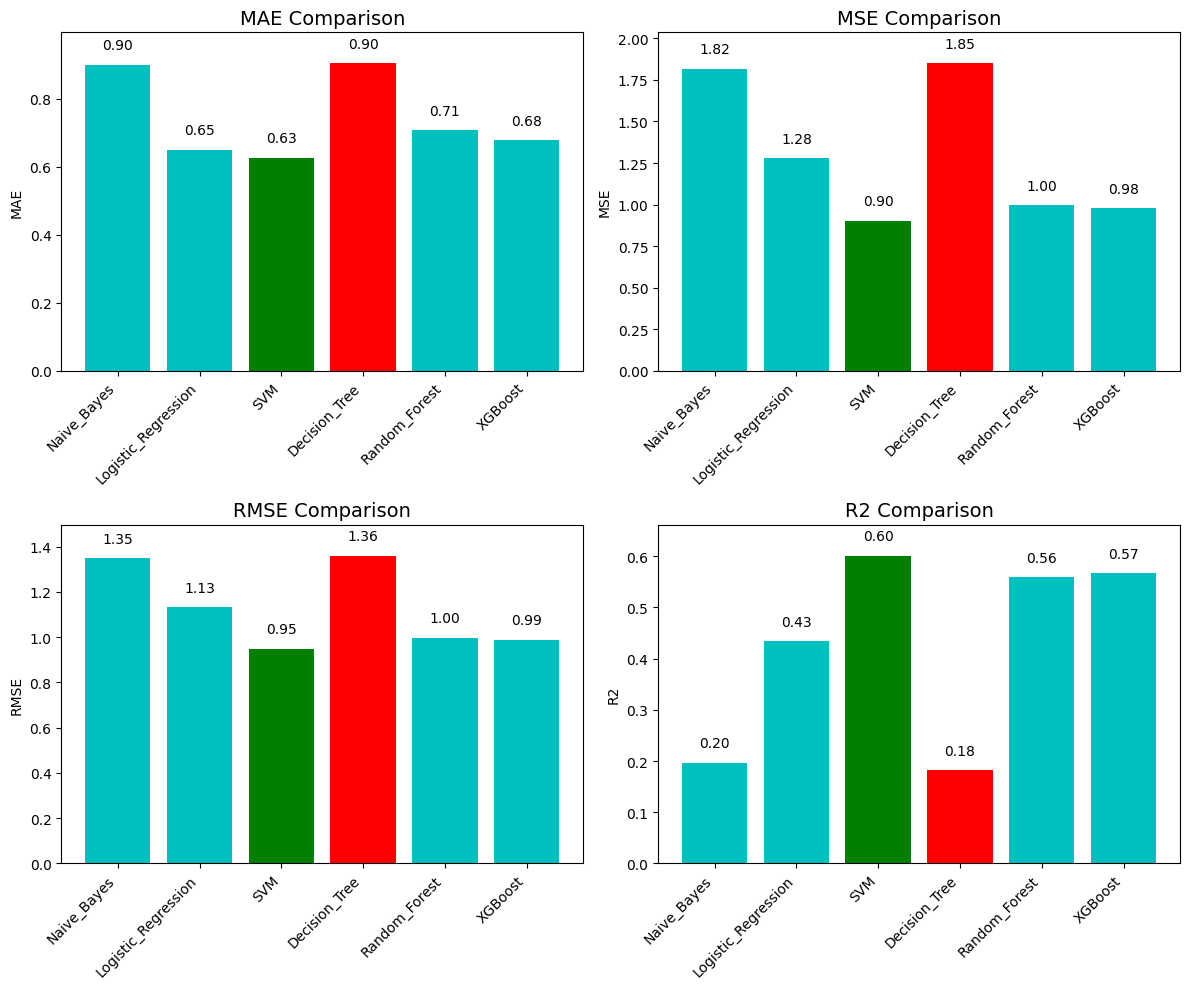

In [ ]:

# Select the metrics to plot
metrics = ["MAE", "MSE", "RMSE", "R2"]
algorithms = ["Linear Regression","Decision_Tree","KNN Regressor", "Random_Forest", "XGBoost","Neuronal Network"]

# Extract values for each metric
values = {metric: [scores[algo][metric] for algo in algorithms] for metric in metrics}

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to iterate easily

for i, metric in enumerate(metrics):
    metric_values = values[metric]

    # Find indices of best and worst models
    best_index = np.argmax(metric_values) if metric == "R2" else np.argmin(metric_values)
    worst_index = np.argmin(metric_values) if metric == "R2" else np.argmax(metric_values)

    # Default color for bars
    colors = ['c'] * len(algorithms)
    colors[best_index] = 'green'  # Best model
    colors[worst_index] = 'red'  # Worst model

    # Create bar plot
    axes[i].bar(algorithms, metric_values, color=colors)
    axes[i].set_title(f"{metric} Comparison", fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(min(metric_values)*1.1 if min(metric_values)<0 else 0, abs(max(metric_values) * 1.1) ) # Adjust y-axis for better visibility
    axes[i].set_xticks(range(len(algorithms)))
    axes[i].set_xticklabels(algorithms, rotation=45, ha="right")

    # Annotate best and worst values
    for j, val in enumerate(metric_values):
        axes[i].text(j, val + (max(metric_values) * 0.05), f"{val:.2f}", ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Error Analysis

Now, we will use our best model results (SVM without tunning) to have a look at the samples that are giving use the biggest discrepancy between the predicted value and the actual value.

In [ ]:
# # Load predictions from the CSV file
# predictions = pd.read_csv("SVM_predictions.csv", header=None).values.flatten()
# predictions = predictions[1:]  # Remove the first row if it's a header
# predictions = list(map(float, predictions))  # Convert each string to float

# # Load actual values from the .npy file
# y_test = np.load("y_test.npy")

# # Ensure that the lengths match
# assert len(predictions) == len(y_test), "The lengths of predictions and y_test do not match"

# # Convert predictions and y_test to NumPy arrays for vectorized operations
# predictions = np.array(predictions)
# y_test = np.array(y_test)

# # Calculate the absolute difference
# difference = np.abs(predictions - y_test)

# # Get the indices where the difference is greater than 3
# indices = np.where(difference > 3)[0]

# # Load the reviews dataset
# dataset_path = "dataset/B2W-Reviews01.csv"
# df = pd.read_csv(dataset_path)

# # Filter rows using the obtained indices
# df_filtered = df.iloc[indices].copy()  # Use .iloc to select by index

# # Add the difference, actual value, and predicted value columns to the filtered dataset
# df_filtered["Difference"] = difference[indices]  # difference[indices] is an array
# df_filtered["Actual Value"] = y_test[indices]     # y_test[indices] is an array
# df_filtered["Predicted Value"] = predictions[indices]  # predictions[indices] is an array

# # Select only the necessary columns
# df_final = df_filtered[["review_text", "Difference", "Actual Value", "Predicted Value"]]

# # Save the new dataset with the filtered reviews
# df_final.to_csv("dataset/reviews_filtered.csv", index=False)


/tmp/ipykernel_3290754/2242411135.py:27: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


We display the ones that show the biggest difference

In [ ]:
pd.set_option('display.max_rows', 100)  # Show all rows
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)  # Show full text without truncation

df_final = df_final.sort_values(by="Difference", ascending=False) # Order by difference

df_final


,review_text,Difference,Actual Value,Predicted Value
11564,"Excelente produto. Retira todos os pelos, sem irritação. Recomendo, com certeza!!!",4.567938,0,4.567938
22057,E pra ser bom e gilette. Se original não tem como ser ruim.,4.476903,4,-0.476903
14504,Fiz 60 km com ela é cedo pra apinar mais é boa pelo preço acho que trocando algumas peças fica melhor pois o quadro não é ruim.,4.461685,4,-0.461685
23395,"CADEIRA SEM ACABAMENTO, CANTOS VIVOS E SEM ERGONOMIA, PARTES INFERIORES SEM VERNIZ. MESA COM TAMPO DE COMPENSADO COM FURO E MANCHAS. O CONJUNTO ATÉ QUE TEM BOA RESISTÊNCIA",4.371343,4,-0.371343
7250,Gostei muito. Em menos de um mês de uso já notei a diferença.,4.369956,4,-0.369956
15617,NaN,4.366932,4,-0.366932
19758,"UM produto muito bom,veio do jeito que pedi ,a entrega foi rapida e funciona perfeitamente.",4.270379,4,-0.270379
20848,Entrega super rápida! Chegou bem antes do previsto!,4.255174,4,-0.255174
12699,"Gostei muito do produto, é um produto fácil e de excelente qualidade",4.252737,4,-0.252737
20058,Produto muito bom.. não trava e ótimo alcance. Fiquei muito satisfeito com esse produto. Superou minhas expectativas.,4.239706,4,-0.239706


In [ ]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


## Conclusion

We started by creating a baseline with different models to establish a starting point. Then, we created a subset containing 10% of the dataset, used GridSearch on different algorithms to test various hyperparameters while performing cross-validation, and finally trained the model with the best parameters using the entire dataset. The results showed no significant improvement over the baseline, which suggests that the bottleneck may lie in the dataset itself. Therefore, further hyperparameter tuning is unlikely to yield major improvements.

After this, we examined the samples with the highest discrepancies and identified several factors that may have limited our training, such as:
* Empty samples (NaN)
* Words in other languages or vulgar language
* Misspellings
* Gibberish
* Brand names or specific terminology
* Incoherent review text or mismatched scores in the dataset